In [11]:
import pandas as pd
import numpy as np
import json
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import Text
import collections

# 데이터 로드

In [12]:
def jsonToDf(file_name):
  with open(file_name, encoding = 'utf-8', mode = 'r') as file:
    json_array = json.load(file)
  
  result = pd.DataFrame.from_dict(json_array[0])

  is_first = True
  for array in json_array:
    if is_first:
      is_first = False
      continue
    
    temp_df = pd.DataFrame.from_dict(array)
    result = result.append(temp_df, ignore_index = True)

  return result

In [13]:
train = jsonToDf('friends_train.json')
dev = jsonToDf('friends_dev.json')
test = jsonToDf('friends_test.json')

## 영문과 공백만 남겨두고 모두 제거

In [14]:
train['utterance'] = train['utterance'].str.replace("[^a-zA-Z]"," ")
test['utterance'] = test['utterance'].str.replace("[^a-zA-Z]"," ")
dev['utterance'] = dev['utterance'].str.replace("[^a-zA-Z]"," ")

## 불용어 제거

In [15]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

def cleaning(str):
    replaceAll = str
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)
    no_capitals = only_english.lower().split()
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xodn0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
train_data=[]
test_data=[]
cols = ['utterance','emotion']

In [17]:
listdict = []
for index, row in train.iterrows():
    rowUtterance = row["utterance"]
    rowEmotion = row["emotion"]
    listdict.append({'utterance':cleaning(rowUtterance),'emotion':rowEmotion})
    train_data = pd.DataFrame(listdict,columns=cols)
    
listdict = []
for index, row in test.iterrows():
    rowUtterance = row["utterance"]
    rowEmotion = row["emotion"]
    listdict.append({'utterance':cleaning(rowUtterance),'emotion':rowEmotion})
    test_data = pd.DataFrame(listdict,columns=cols)
    
listdict = []
for index, row in dev.iterrows():
    rowUtterance = row["utterance"]
    rowEmotion = row["emotion"]
    listdict.append({'utterance':cleaning(rowUtterance),'emotion':rowEmotion})
    test_data = pd.DataFrame(listdict,columns=cols)

In [18]:
train_data

,utterance,emotion
0,also point person compani transit kl gr system,neutral
1,must hand full,neutral
2,,neutral
3,let talk littl bit duti,neutral
4,duti right,surprise
...,...,...
10556,,neutral
10557,got uh joey women adam appl,non-neutral
10558,guy mess right,surprise
10559,yeah,neutral


## 결측치 데이터 삭제

In [19]:
print("train_data 널값 존재 여부 : "+ str(train_data.isnull().values.any())) # 널값 존재 확인
print(train_data.isnull().sum())
print("=====================")
print("test_data 널값 존재 여부 : "+ str(test_data.isnull().values.any())) # 널값 존재 확인
print(test_data.isnull().sum())


train_data 널값 존재 여부 : False
utterance    0
emotion      0
dtype: int64
test_data 널값 존재 여부 : False
utterance    0
emotion      0
dtype: int64


In [20]:
train_data['utterance'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any') # 널값 존재 행 제거
print(train_data.isnull().sum())
print("train_data 널값 존재 여부 : "+ str(train_data.isnull().values.any())) # 널값 존재 확인
print("=====================")
test_data['utterance'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any') # 널값 존재 행 제거
print(test_data.isnull().sum())
print("test_data 널값 존재 여부 : "+ str(test_data.isnull().values.any())) # 널값 존재 확인

utterance    0
emotion      0
dtype: int64
train_data 널값 존재 여부 : False
utterance    0
emotion      0
dtype: int64
test_data 널값 존재 여부 : False


## 중복제거

In [21]:
print("train_data 총건수 : " + str(len(train_data)))
print("train_data document 중복제외건수(유니크)) : " + str(train_data['utterance'].nunique()))
print("train_data label 중복제외건수(유니크)) : " + str(train_data['emotion'].nunique()))
print("================================")
print("test_data 총건수 : " + str(len(test_data)))
print("test_data document 중복제외건수(유니크)) : " + str(test_data['utterance'].nunique()))
print("test_data label 중복제외건수(유니크)) : " + str(test_data['emotion'].nunique()))

train_data 총건수 : 10011
train_data document 중복제외건수(유니크)) : 8008
train_data label 중복제외건수(유니크)) : 8
test_data 총건수 : 1108
test_data document 중복제외건수(유니크)) : 966
test_data label 중복제외건수(유니크)) : 8


In [22]:
train_data.drop_duplicates(subset=['utterance'], inplace=True) # train_data document 중복제거 수행
test_data.drop_duplicates(subset=['utterance'], inplace=True) # test_data document 중복제거 수행

D:\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
print('train_data 중복제거한 총건수 :',len(train_data))
print('test_data 중복제거한 총건수 :',len(test_data))

train_data 중복제거한 총건수 : 8008
test_data 중복제거한 총건수 : 966


In [24]:
train_data

,utterance,emotion
0,also point person compani transit kl gr system,neutral
1,must hand full,neutral
3,let talk littl bit duti,neutral
4,duti right,surprise
5,head whole divis lot duti,neutral
...,...,...
10554,first move citi went coupl time girl realli ho...,disgust
10555,made nut,disgust
10557,got uh joey women adam appl,non-neutral
10558,guy mess right,surprise


## train_data 불용어 제거

In [25]:
okt = Okt()

X_train = []
for sentence in train_data['utterance']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stops]
    X_train.append(temp_X)

## test_data 불용어 제거

In [26]:
X_test = []
for sentence in test_data['utterance']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stops]
    X_test.append(temp_X)

# 토큰화

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## 정수인코딩

In [28]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4158
등장 빈도가 2번 이하인 희귀 단어의 수: 2566
단어 집합에서 희귀 단어의 비율: 61.712361712361705
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.595376503988103


In [29]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1594


In [30]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
def labeltoint(str):
    return {'non-neutral': 0,
             'neutral': 1, 
             'joy': 2,
             'sadness': 3,
             'fear': 4,
             'anger': 5,
             'surprise': 6,
             'disgust': 7}[str]

labels = []
for i in train_data['emotion']:
    labels.append(labeltoint(i))
y_train = np.array(labels)

labels = []
for i in test_data['emotion']:
    labels.append(labeltoint(i))
y_test = np.array(labels)

In [32]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [33]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

8008
8008


D:\Anaconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩

리뷰의 최대 길이 : 33
리뷰의 평균 길이 : 4.6185064935064934


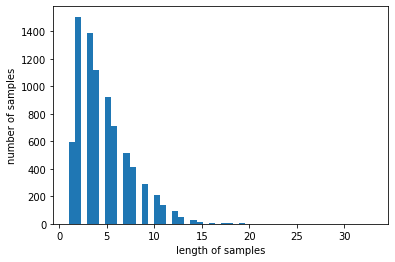

In [34]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [36]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.98751248751249


In [37]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# LSTM 모델 학습

In [38]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100))
model.add(Dense(1, activation='softmax'))

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
126/126 [==============================] - 5s 25ms/step - loss: 0.0000e+00 - acc: 0.4448 - val_loss: 0.0000e+00 - val_acc: 0.3965

Epoch 00001: val_acc improved from -inf to 0.39648, saving model to best_model.h5
Epoch 2/15
126/126 [==============================] - 3s 21ms/step - loss: 0.0000e+00 - acc: 0.4468 - val_loss: 0.0000e+00 - val_acc: 0.3965

Epoch 00002: val_acc did not improve from 0.39648
Epoch 3/15
126/126 [==============================] - 3s 21ms/step - loss: 0.0000e+00 - acc: 0.4380 - val_loss: 0.0000e+00 - val_acc: 0.3965

Epoch 00003: val_acc did not improve from 0.39648
Epoch 4/15
126/126 [==============================] - 3s 22ms/step - loss: 0.0000e+00 - acc: 0.4419 - val_loss: 0.0000e+00 - val_acc: 0.3965

Epoch 00004: val_acc did not improve from 0.39648
Epoch 5/15
126/126 [==============================] - 3s 23ms/step - loss: 0.0000e+00 - acc: 0.4398 - val_loss: 0.0000e+00 - val_acc: 0.3965

Epoch 00005: val_acc did not improve from 0.39648
Epoch 00

In [46]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

31/31 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - acc: 0.3965

 테스트 정확도: 0.3965


In [47]:
def inttolabel(idx):
    return {0:'non-neutral',
             1:'neutral', 
             2:'joy',
             3:'sadness',
             4:'fear',
             5:'anger',
             6:'surprise',
             7:'disgust'}[idx]

In [48]:
def sentiment_predict2(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stops] # 불용어 제거
    print(new_sentence)
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    print(encoded)
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    print(pad_new)
    score = model.predict(pad_new) # 예측
    print(score[0])
    c = 0
    cnt = 0
    for y in score[0]:
        if c < y:
            c = y
            ans = cnt
            print(ans)
        cnt += 1
    ans = inttolabel(ans)
    return ans

In [49]:
sentiment_predict2("oh my god")

['oh', 'god']
[[2, 34]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2 34]]
[1.]
0


'non-neutral'

In [125]:
def predict(text): 
    aa = pos_tag(word_tokenize(text))
    print(aa)
    pp = []
    for t in aa:
        pp.append("/".join(t))
    wids = [word2index[word] for word in pp]
    x_predict = pad_sequences([wids], maxlen=maxlen) 
    y_predict = loaded_model.predict(x_predict) 
    c = 0
    cnt = 0
    for y in y_predict[0]:
        if c < y:
            c = y
            ans = cnt
        cnt += 1
    ans = inttolabel(ans)
    return ans;

In [43]:
data = pd.read_csv('en_data.csv', encoding='utf-8')

In [44]:
data

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!
...,...,...,...,...,...
1618,1618,150,14,Joey,Nooo.
1619,1619,150,15,Lauren,"Hi, Kate!"
1620,1620,150,16,Kate,"Hi, Lauren."
1621,1621,150,17,Joey,"Hi, Lauren."


In [45]:
cols = ['Id','Expected']
listdict = []

In [46]:
for index, row in data.iterrows():
    rowId = row["id"]
    rowutterance = row["utterance"]
    result = sentiment_predict2(rowutterance)
    print(result)
    listdict.append({'Id':str(rowId),'Expected':str(result)})
    output = pd.DataFrame(listdict,columns=cols)

[0.50466734]
0
non-neutral
[0.50379324]
0
non-neutral
[0.5031044]
0
non-neutral
[0.5067924]
0
non-neutral
[0.5014339]
0
non-neutral
[0.5054179]
0
non-neutral
[0.5022686]
0
non-neutral
[0.5060347]
0
non-neutral
[0.5043827]
0
non-neutral
[0.5051138]
0
non-neutral
[0.5047591]
0
non-neutral
[0.5056074]
0
non-neutral
[0.5007405]
0
non-neutral
[0.5029066]
0
non-neutral
[0.5034173]
0
non-neutral
[0.50686175]
0
non-neutral
[0.5018756]
0
non-neutral
[0.5036519]
0
non-neutral
[0.50374055]
0
non-neutral
[0.5033464]
0
non-neutral
[0.5047266]
0
non-neutral
[0.5074132]
0
non-neutral
[0.5023216]
0
non-neutral
[0.50616]
0
non-neutral
[0.50173974]
0
non-neutral
[0.50431716]
0
non-neutral
[0.50431716]
0
non-neutral
[0.4958855]
0
non-neutral
[0.5019954]
0
non-neutral
[0.5066238]
0
non-neutral
[0.50171584]
0
non-neutral
[0.50445265]
0
non-neutral
[0.50269794]
0
non-neutral
[0.50485873]
0
non-neutral
[0.5039052]
0
non-neutral
[0.5069343]
0
non-neutral
[0.50378764]
0
non-neutral
[0.49969676]
0
non-neutral
[

[0.5018785]
0
non-neutral
[0.50569075]
0
non-neutral
[0.5063753]
0
non-neutral
[0.5069343]
0
non-neutral
[0.50340825]
0
non-neutral
[0.5047836]
0
non-neutral
[0.503603]
0
non-neutral
[0.50246114]
0
non-neutral
[0.50520635]
0
non-neutral
[0.50494176]
0
non-neutral
[0.5049432]
0
non-neutral
[0.50366986]
0
non-neutral
[0.5034827]
0
non-neutral
[0.5009313]
0
non-neutral
[0.502646]
0
non-neutral
[0.50108695]
0
non-neutral
[0.5045677]
0
non-neutral
[0.50534916]
0
non-neutral
[0.5047986]
0
non-neutral
[0.50462973]
0
non-neutral
[0.50212455]
0
non-neutral
[0.5048583]
0
non-neutral
[0.50290054]
0
non-neutral
[0.5012129]
0
non-neutral
[0.50226957]
0
non-neutral
[0.5028201]
0
non-neutral
[0.50582045]
0
non-neutral
[0.501581]
0
non-neutral
[0.50207424]
0
non-neutral
[0.50012505]
0
non-neutral
[0.50710106]
0
non-neutral
[0.50458306]
0
non-neutral
[0.5018411]
0
non-neutral
[0.5017349]
0
non-neutral
[0.5019771]
0
non-neutral
[0.5039617]
0
non-neutral
[0.50275946]
0
non-neutral
[0.5041535]
0
non-neutr

[0.50866747]
0
non-neutral
[0.5040917]
0
non-neutral
[0.5059774]
0
non-neutral
[0.5016929]
0
non-neutral
[0.5004451]
0
non-neutral
[0.5046582]
0
non-neutral
[0.5043912]
0
non-neutral
[0.5059139]
0
non-neutral
[0.50613904]
0
non-neutral
[0.50165004]
0
non-neutral
[0.5028769]
0
non-neutral
[0.501713]
0
non-neutral
[0.50192946]
0
non-neutral
[0.5036502]
0
non-neutral
[0.50194955]
0
non-neutral
[0.50330997]
0
non-neutral
[0.5052403]
0
non-neutral
[0.50611]
0
non-neutral
[0.50866747]
0
non-neutral
[0.5031653]
0
non-neutral
[0.5033512]
0
non-neutral
[0.5044185]
0
non-neutral
[0.50534683]
0
non-neutral
[0.50561494]
0
non-neutral
[0.5041509]
0
non-neutral
[0.50716496]
0
non-neutral
[0.50301564]
0
non-neutral
[0.5048042]
0
non-neutral
[0.5052891]
0
non-neutral
[0.5046025]
0
non-neutral
[0.50483054]
0
non-neutral
[0.50384504]
0
non-neutral
[0.504379]
0
non-neutral
[0.50875205]
0
non-neutral
[0.50331736]
0
non-neutral
[0.5014771]
0
non-neutral
[0.5040755]
0
non-neutral
[0.5062829]
0
non-neutral
[

[0.50354326]
0
non-neutral
[0.5042289]
0
non-neutral
[0.5018479]
0
non-neutral
[0.5013333]
0
non-neutral
[0.50380564]
0
non-neutral
[0.5062462]
0
non-neutral
[0.50316024]
0
non-neutral
[0.503574]
0
non-neutral
[0.50493777]
0
non-neutral
[0.50250334]
0
non-neutral
[0.5030686]
0
non-neutral
[0.50440264]
0
non-neutral
[0.5047156]
0
non-neutral
[0.5036094]
0
non-neutral
[0.50125843]
0
non-neutral
[0.5023891]
0
non-neutral
[0.5025497]
0
non-neutral
[0.50710106]
0
non-neutral
[0.5049344]
0
non-neutral
[0.5067924]
0
non-neutral
[0.5024353]
0
non-neutral
[0.5019891]
0
non-neutral
[0.50686175]
0
non-neutral
[0.50592333]
0
non-neutral
[0.50690836]
0
non-neutral
[0.50866747]
0
non-neutral
[0.5019829]
0
non-neutral
[0.50157785]
0
non-neutral
[0.50477076]
0
non-neutral
[0.5085369]
0
non-neutral
[0.5047048]
0
non-neutral
[0.507377]
0
non-neutral
[0.50615263]
0
non-neutral
[0.5025207]
0
non-neutral
[0.5065621]
0
non-neutral
[0.5019811]
0
non-neutral
[0.5038161]
0
non-neutral
[0.50310975]
0
non-neutra

[0.49987102]
0
non-neutral
[0.50175333]
0
non-neutral
[0.5057754]
0
non-neutral
[0.5055283]
0
non-neutral
[0.50768274]
0
non-neutral
[0.5002244]
0
non-neutral
[0.5045579]
0
non-neutral
[0.5028999]
0
non-neutral
[0.5039587]
0
non-neutral
[0.5061072]
0
non-neutral
[0.50273025]
0
non-neutral
[0.5046971]
0
non-neutral
[0.5061619]
0
non-neutral
[0.50925964]
0
non-neutral
[0.5004923]
0
non-neutral
[0.5065621]
0
non-neutral
[0.5035096]
0
non-neutral
[0.50710106]
0
non-neutral
[0.5025383]
0
non-neutral
[0.5074391]
0
non-neutral
[0.50843674]
0
non-neutral
[0.5045244]
0
non-neutral
[0.4996594]
0
non-neutral
[0.5017223]
0
non-neutral
[0.5002414]
0
non-neutral
[0.505165]
0
non-neutral
[0.50568986]
0
non-neutral
[0.502662]
0
non-neutral
[0.5011564]
0
non-neutral
[0.5009711]
0
non-neutral
[0.49996132]
0
non-neutral
[0.50783956]
0
non-neutral
[0.49838898]
0
non-neutral
[0.50443035]
0
non-neutral
[0.50073504]
0
non-neutral
[0.5042852]
0
non-neutral
[0.5051612]
0
non-neutral
[0.5036216]
0
non-neutral
[

[0.50600004]
0
non-neutral
[0.5042706]
0
non-neutral
[0.504143]
0
non-neutral
[0.5081112]
0
non-neutral
[0.5016212]
0
non-neutral
[0.50866747]
0
non-neutral
[0.50866747]
0
non-neutral
[0.50194895]
0
non-neutral
[0.5058254]
0
non-neutral
[0.5030383]
0
non-neutral
[0.5045905]
0
non-neutral
[0.5051784]
0
non-neutral
[0.49897748]
0
non-neutral
[0.50327766]
0
non-neutral
[0.50561136]
0
non-neutral
[0.5067924]
0
non-neutral
[0.50191206]
0
non-neutral
[0.50427675]
0
non-neutral
[0.50186795]
0
non-neutral
[0.5073567]
0
non-neutral
[0.50425655]
0
non-neutral
[0.5055954]
0
non-neutral
[0.5067924]
0
non-neutral
[0.50866747]
0
non-neutral
[0.50866747]
0
non-neutral
[0.506349]
0
non-neutral
[0.50389946]
0
non-neutral
[0.5058371]
0
non-neutral
[0.50252366]
0
non-neutral
[0.5028781]
0
non-neutral
[0.5040574]
0
non-neutral
[0.50506514]
0
non-neutral
[0.5029835]
0
non-neutral
[0.5032008]
0
non-neutral
[0.50264627]
0
non-neutral
[0.5077406]
0
non-neutral
[0.49889487]
0
non-neutral
[0.5051989]
0
non-neut

In [66]:
output.to_csv('sample_en_cnn.csv', index=False)